In [2]:
from utils.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.LSTM import *
import yaml

### **Score**

Trafe-off entre el hit-rate y el MSE. 

$Score(h,m)=\lambda \cdot (1-h)+(1-lambda) \cdot m$

In [3]:
stocks = ["MSFT", "CMCSA", "COST", "AAPL", "QCOM", "ADBE", "SBUX", "INTU", "AMD", "INTC"]
dfs = {s: pd.read_csv(f"./prices/{s}_prices.csv", index_col=0, parse_dates=True) for s in stocks}


start_day    = "2025-01-01"

horizon_days = 50                           # cantidad de días hábiles a predecir
training_years = 2                         # años previos para entrenar y predecir cada día

stock = "AAPL"
feat_cols = ["Close","Volume","High","Low","Open"]

In [4]:
# TRAINING
##########
results = []
hit_coefs = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
for hit_coef in tqdm(hit_coefs):
    res = walk_forward_predict(     LSTMRegressor,
                                    dfs, 
                                    stock,
                                    start_day, 
                                    horizon_days,
                                    training_years=training_years,
                                    feat_cols=feat_cols,

                                    W=50,
                                    
                                    # lstm
                                    hidden_size=64, 
                                    num_layers=2, 
                                    dropout=0.0037,
                                    hit_coef=hit_coef,
                                    batch_size=8, 
                                    epochs=40, 
                                    lr= 0.00327,
                                    patience=5,
                                    
                                    torch_seed=0,
                                    model = 'LSTM+GNN',
                                    tau_pear = 0.5,
                                    tau_lift = 1.2,
                                    alpha = 1
                                )
    
    res_df = res[0]
    mse = float(np.mean((res_df["y_pred_norm"] - res_df["y_true_norm"])**2))
    _hit_rate = hit_rate(res[0], dfs[stock])
    print(f"hit_coef = {hit_coef} | MSE = {mse:.6} | Hit Rate = {_hit_rate:.2%} ")
    results.append({
        "stock": stock,
        "hit_coef":hit_coef,
        "res":res,
        "mse":mse
    })

 10%|█         | 1/10 [03:14<29:12, 194.74s/it]

hit_coef = 0 | MSE = 0.00155203 | Hit Rate = 46.00% 


 20%|██        | 2/10 [06:23<25:27, 190.98s/it]

hit_coef = 0.01 | MSE = 0.00160919 | Hit Rate = 52.00% 


 30%|███       | 3/10 [09:50<23:10, 198.66s/it]

hit_coef = 0.02 | MSE = 0.00165927 | Hit Rate = 48.00% 


 40%|████      | 4/10 [13:23<20:25, 204.19s/it]

hit_coef = 0.03 | MSE = 0.00185251 | Hit Rate = 48.00% 


 50%|█████     | 5/10 [16:53<17:11, 206.29s/it]

hit_coef = 0.04 | MSE = 0.0018651 | Hit Rate = 42.00% 


 60%|██████    | 6/10 [20:09<13:31, 202.89s/it]

hit_coef = 0.05 | MSE = 0.00173536 | Hit Rate = 50.00% 


 70%|███████   | 7/10 [23:22<09:58, 199.52s/it]

hit_coef = 0.06 | MSE = 0.00162185 | Hit Rate = 50.00% 


 80%|████████  | 8/10 [26:38<06:36, 198.29s/it]

hit_coef = 0.07 | MSE = 0.00156469 | Hit Rate = 48.00% 


 90%|█████████ | 9/10 [29:51<03:16, 196.87s/it]

hit_coef = 0.08 | MSE = 0.00169387 | Hit Rate = 46.00% 


100%|██████████| 10/10 [33:17<00:00, 199.78s/it]

hit_coef = 0.09 | MSE = 0.00157572 | Hit Rate = 48.00% 


Mejor hit_coef según score combinado (λ=0.7): 0.01


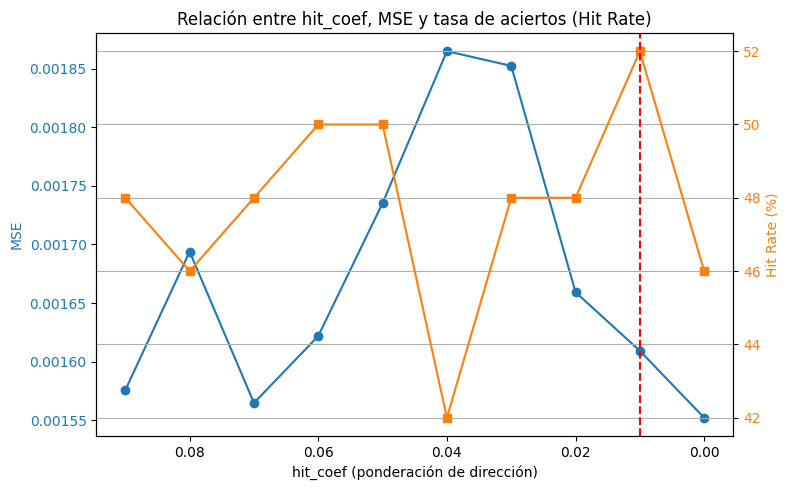

In [5]:
import matplotlib.pyplot as plt
import numpy as np

hit_rates = [hit_rate(res["res"][0], dfs[stock]) for res in results]
mses = [float(np.mean((res["res"][0]["y_pred_norm"] - res["res"][0]["y_true_norm"])**2)) for res in results]


# Score
lamb = 0.7  # por ejemplo, valorás más la dirección
scores = [lamb * (1 - h) + (1 - lamb) * m for h, m in zip(hit_rates, mses)]

best_index = int(np.argmin(scores))
best_hit_coef = hit_coefs[best_index]

print(f"Mejor hit_coef según score combinado (λ={lamb}): {best_hit_coef}")

# crear figura y ejes
fig, ax1 = plt.subplots(figsize=(8,5))

color1 = "#1f77b4"  # azul
color2 = "#ff7f0e"  # naranja

# --- eje izquierdo: MSE ---
ax1.set_xlabel("hit_coef (ponderación de dirección)")
ax1.set_ylabel("MSE", color=color1)
ax1.plot(hit_coefs, mses, color=color1, marker="o", label="MSE")
ax1.tick_params(axis="y", labelcolor=color1)
ax1.invert_xaxis()  # opcional: que los valores grandes de coef estén a la izquierda

# --- eje derecho: Hit Rate ---
ax2 = ax1.twinx()
ax2.set_ylabel("Hit Rate (%)", color=color2)
ax2.plot(hit_coefs, np.array(hit_rates)*100, color=color2, marker="s", label="Hit Rate")
ax2.tick_params(axis="y", labelcolor=color2)

# título y estética
plt.title("Relación entre hit_coef, MSE y tasa de aciertos (Hit Rate)")
fig.tight_layout()
plt.axvline(x=best_hit_coef, color='red', linestyle='--')
plt.grid()
plt.show()